In [1]:
import networkx as nx
import torch
import pandas as pd
import itertools
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.utils import negative_sampling, train_test_split_edges
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.loader import LinkNeighborLoader
import torch_geometric.transforms as T
import pyg_lib
from torch import Tensor
from torch_geometric.nn import SAGEConv
import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import NNConv

In [ ]:
def explode_combinations_with_inparalogs(df, cols_to_explode,
                                         protein_col='protein/inparalogs',
                                         ortholog_col='orthologs',
                                         taxid_col='taxid',
                                         ortholog_taxid_col='ortholog_taxid'):
    for col in cols_to_explode:
        df[col] = df[col].str.split(',')
    df_expanded = df.copy()
    for col in cols_to_explode:
        df_expanded = df_expanded.explode(col, ignore_index=True)
    new_rows = []
    for _, row in df.iterrows():
        proteins = row[protein_col]
        taxid = row[taxid_col]
        if isinstance(proteins, list) and len(proteins) > 1:
            for p1, p2 in itertools.combinations(proteins, 2):
                new_rows.append({
                    taxid_col: taxid,
                    protein_col: p1,
                    ortholog_col: p2,
                    ortholog_taxid_col: taxid
                })
    if new_rows:
        df_expanded_inpara = pd.DataFrame(new_rows, columns=["taxid", "protein/inparalogs", "orthologs", "ortholog_taxid"])
    return df_expanded, df_expanded_inpara

def graph_summary(G, cc):
    print("Nombre de nœuds : ", G.number_of_nodes())
    print("Nombre d’arêtes : ", G.number_of_edges())

    print("Nombre de composantes connexes : ", len(cc))
    print(f"Composante la plus grande : ", len(max(cc, key=len)))



def ortho_graph_total(path_taxid):

    #Importe liste des espèces
    id_list = []
    with open(path_taxid) as id_file:
        for l in id_file:
            id_list.append(int(l.strip()))
    print("Chargement : ", len(id_list), " espèces")

    #Importe fichiers d'orthologies
    df_ortho = pd.DataFrame(columns=["taxid", "protein/inparalogs", "orthologs", "ortholog_taxid"])
    for id in id_list:
        df = pd.read_csv("/home/schoenstein/these/test_gnn/data/" + str(id) + ".tsv", sep = "\t")
        df = df[df['ortholog_taxid'].isin(id_list)]
        df["taxid"] = id
        df_ortho = pd.concat([df_ortho, df], ignore_index = True)
    
    #Etale les paralogues
    cols_to_explode = ['protein/inparalogs', 'orthologs']
    df_ortho_split, df_inpara_split = explode_combinations_with_inparalogs(df_ortho, cols_to_explode)
    print(df_ortho_split)
    print("Chargement : ", len(df_ortho_split), " relations")

    #Crée graphe
    edges_ortho = list(zip(df_ortho_split['protein/inparalogs'], df_ortho_split['orthologs']))
    edges_inpara = list(zip(df_inpara_split['protein/inparalogs'], df_inpara_split['orthologs']))
    G = nx.Graph()
    G.add_edges_from(edges_ortho, label = "ortho")
    G.add_edges_from(edges_inpara, label = "inpara")

    #Attribue les espèces à chaque noeud
    node_taxid = pd.concat([
        df_ortho_split[['protein/inparalogs','taxid']].rename(columns={'protein/inparalogs':'node','taxid':'taxid'}),
        df_ortho_split[['orthologs','ortholog_taxid']].rename(columns={'orthologs':'node','ortholog_taxid':'taxid'})
    ])
    node_taxid_dict = pd.Series(node_taxid['taxid'].values, index=node_taxid['node']).to_dict()
    nx.set_node_attributes(G, node_taxid_dict, name='taxid')

    #Composantes connexes et leurs tailles
    cc = sorted(list(nx.connected_components(G)), key = len, reverse = True)
    list_taille = []
    for c in cc:
        list_taille.append(len(c))

    #Statistiques de base du graph
    graph_summary(G, cc)

    return G

In [ ]:
G = ortho_graph_total("/home/schoenstein/these/test_gnn/id_list_metazoa_reduce.txt")
data = from_networkx(G)
print(data)
species = [G.nodes[n]['taxid'] for n in G.nodes()]
species_tensor = torch.tensor(LabelEncoder().fit_transform(species), dtype=torch.long)
species_one_hot = F.one_hot(species_tensor).float()
data.x = species_one_hot

edge_labels = [G.edges[e]['label'] for e in G.edges()]
edge_tensor = torch.tensor(LabelEncoder().fit_transform(edge_labels), dtype=torch.long)
edge_label_tensor = torch.cat([edge_tensor, edge_tensor], dim=0)
edge_one_hot = F.one_hot(edge_label_tensor).float()
data.edge_type = edge_one_hot


for key in list(data.keys()):
    if key not in ['x', 'edge_index', 'edge_type']:
        del data[key]

print(data)

Chargement :  3  espèces
      taxid protein/inparalogs   orthologs ortholog_taxid
0      7741         A0A6P5AHG9      W5LZN0           7918
1      7741         A0A6P5AMR1      W5M0K9           7918
2      7741         A0A6P4ZUP5      W5M1I4           7918
3      7741         A0A6P4YNN3      W5M5L0           7918
4      7741         A0A6P5AKH2      W5M5R0           7918
...     ...                ...         ...            ...
83509  7918             W5N1A9  A0A6P4ZN16           7741
83510  7918             W5MVK8      Q9U637           7741
83511  7918             W5MVK8  A0A6P4ZN16           7741
83512  7918             W5MTI1      Q9U637           7741
83513  7918             W5MTI1  A0A6P4ZN16           7741

[83514 rows x 4 columns]
Chargement :  83514  relations
Nombre de nœuds :  38862
Nombre d’arêtes :  63847
Nombre de composantes connexes :  11015
Composante la plus grande :  103
Data(edge_index=[2, 127694], taxid=[38862], label=[127694], num_nodes=38862)
Data(edge_index=[2, 12

In [11]:
transform = T.RandomLinkSplit(
    num_val= 0.1,  
    num_test= 0.1,  
    disjoint_train_ratio= 0.3,  
    neg_sampling_ratio= 2,
    is_undirected = True
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
Data(edge_index=[2, 71512], x=[38862, 3], edge_type=[71512, 2], edge_label=[45969], edge_label_index=[2, 45969])

Validation data:
Data(edge_index=[2, 102158], x=[38862, 3], edge_type=[102158, 2], edge_label=[19152], edge_label_index=[2, 19152])


In [12]:
train_loader = LinkNeighborLoader(
    data = train_data,  
    num_neighbors = [20,10],  
    #neg_sampling_ratio = 2,  
    neg_sampling_ratio = 1,  
    edge_label_index=train_data.edge_label_index,
    edge_label=train_data.edge_label,
    batch_size=128,
    shuffle=True,
)

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_dim):
        super().__init__()
        nn1 = Sequential(Linear(edge_dim, in_channels * hidden_channels), ReLU())
        nn2 = Sequential(Linear(edge_dim, hidden_channels * hidden_channels), ReLU())
        
        self.conv1 = NNConv(in_channels, hidden_channels, nn1, aggr='mean')
        self.conv2 = NNConv(hidden_channels, hidden_channels, nn2, aggr='mean')

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x

class Classifier(torch.nn.Module):
    def forward(self, x: Tensor, edge_label_index: Tensor) -> Tensor:
        edge_feat_src = x[edge_label_index[0]]
        edge_feat_dst = x[edge_label_index[1]]

        edge_feat_src = F.normalize(edge_feat_src, dim=-1)
        edge_feat_dst = F.normalize(edge_feat_dst, dim=-1)

        pred = (edge_feat_src * edge_feat_dst).sum(dim=-1)
        return pred

class Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_dim):
        super().__init__()
        self.gnn = GNN(in_channels, hidden_channels, edge_dim=edge_dim)
        self.classifier = Classifier()

    def forward(self, data) -> Tensor:
        x = self.gnn(data.x, data.edge_index, data.edge_type)
        pred = self.classifier(x, data.edge_label_index)
        return pred

model = Model(in_channels=train_data.x.shape[1], hidden_channels=64, edge_dim=train_data.edge_type.shape[1])

print(model)


Model(
  (gnn): GNN(
    (conv1): NNConv(3, 64, aggr=mean, nn=Sequential(
      (0): Linear(in_features=2, out_features=192, bias=True)
      (1): ReLU()
    ))
    (conv2): NNConv(64, 64, aggr=mean, nn=Sequential(
      (0): Linear(in_features=2, out_features=4096, bias=True)
      (1): ReLU()
    ))
  )
  (classifier): Classifier()
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

for epoch in range(1, 4):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        pred = model(sampled_data)
        y = sampled_data.edge_label.float()
        loss = F.binary_cross_entropy_with_logits(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")
    if epoch % 1 == 0:
        print(f"Epoch {epoch}")
        print("  grad mean:", sum(p.grad.abs().mean().item() for p in model.parameters() if p.grad is not None))
        print("  pred mean:", pred.mean().item(), "pred std:", pred.std().item())

torch.save(model, "trained_model.pt") #torch.save(model.state_dict(), "trained_model.pt") marcherait mieux apparement

In [ ]:
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio = 0,
    edge_label_index=val_data.edge_label_index,
    edge_label=val_data.edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        pred = model(sampled_data)
        y = sampled_data.edge_label.float()
        preds.append(pred)
        ground_truths.append(y)

pred = torch.cat(preds, dim=0).numpy()
ground_truth = torch.cat(ground_truths, dim=0).numpy()
auc = roc_auc_score(ground_truth, pred)
print(f"Validation AUC: {auc:.4f}")

In [ ]:
G2 = ortho_graph_total("/home/schoenstein/these/test_gnn/id_list_metazoa_reduce2.txt")
data2 = from_networkx(G2)
species = [G2.nodes[n]['taxid'] for n in G2.nodes()]
species_tensor = torch.tensor(LabelEncoder().fit_transform(species), dtype=torch.long)
species_one_hot = F.one_hot(species_tensor).float()
data2.x = species_one_hot

edge_labels = [G2.edges[e]['label'] for e in G2.edges()]
edge_tensor = torch.tensor(LabelEncoder().fit_transform(edge_labels), dtype=torch.long)
edge_label_tensor = torch.cat([edge_tensor, edge_tensor], dim=0)
edge_one_hot = F.one_hot(edge_label_tensor).float()
data2.edge_type = edge_one_hot


for key in list(data2.keys()):
    if key not in ['x', 'edge_index', 'edge_type']:
        del data2[key]

print(data2)

Chargement :  3  espèces
        taxid protein/inparalogs   orthologs ortholog_taxid
0       31033             H2V8F6      A0A182           7955
1       31033             H2V9W2  A0A286Y8B5           7955
2       31033             H2TMA1  A0A8M1N2B9           7955
3       31033         A0A3B5K4M3  A0A8M1N6K4           7955
4       31033             H2RKR8  A0A8M1NF74           7955
...       ...                ...         ...            ...
116291  27687         A0A8C4SMW3  A0A674MSB8          31033
116292  27687         A0A8C4SMW3  A0A674PKF2          31033
116293  27687         A0A8C4SMW3  A0A674N736          31033
116294  27687         A0A8C4SMW3  A0A674NFW3          31033
116295  27687         A0A8C4SMW3  A0A3B5KT58          31033

[116296 rows x 4 columns]
Chargement :  116296  relations
Nombre de nœuds :  52379
Nombre d’arêtes :  104879
Nombre de composantes connexes :  16027
Composante la plus grande :  298
Data(edge_index=[2, 209758], x=[52379, 3], edge_type=[209758, 2])


In [16]:
data2.edge_label_index = data2.edge_index
model = Model(in_channels=train_data.x.shape[1], hidden_channels=64, edge_dim=train_data.edge_type.shape[1])
model = torch.load("trained_model.pt")
with torch.no_grad():
    pred = model(data2)
proba = torch.sigmoid(pred)

pred_df = pd.DataFrame({
    "node1": data2.edge_label_index[0].cpu().numpy(),
    "node2": data2.edge_label_index[1].cpu().numpy(),
    "score": proba.cpu().numpy()
}).sort_values("score", ascending=True)

print(pred_df.head(10))

/tmp/ipykernel_1470890/832897888.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("trained_model.pt")


        node1  node2     score
118986  33049  33050  0.312135
118987  33050  33049  0.312135
15124    7707  42950  0.315086
138702  42950   7707  0.315086
128396  37777  50270  0.315568
177570  50270  37777  0.315568
123180  35163   4647  0.320790
9054     4647  35163  0.320790
10515    5406   5407  0.323186
10517    5407   5406  0.323186


In [18]:
idx_to_node = dict(enumerate(G2.nodes()))
pred_df["node1"] = pred_df["node1"].map(idx_to_node)
pred_df["node2"] = pred_df["node2"].map(idx_to_node)

In [19]:
print(pred_df.head(10))

             node1       node2     score
118986  A0A674NLT1  A0A8C4SZU3  0.312135
118987  A0A8C4SZU3  A0A674NLT1  0.312135
15124       F1QIL3  A0A8C4SLT4  0.315086
138702  A0A8C4SLT4      F1QIL3  0.315086
128396  A0A8C4TMI7      O13109  0.315568
177570      O13109  A0A8C4TMI7  0.315568
123180  A0A8C4S2G0      A5PLF8  0.320790
9054        A5PLF8  A0A8C4S2G0  0.320790
10515   A0A674N3B6      Q6P3K2  0.323186
10517       Q6P3K2  A0A674N3B6  0.323186


In [20]:
pred_df["taxid_1"] = pred_df["node1"].apply(lambda n: G2.nodes[n]["taxid"])
pred_df["taxid_2"] = pred_df["node2"].apply(lambda n: G2.nodes[n]["taxid"])

In [21]:
print(pred_df.head(10))

             node1       node2     score  taxid_1  taxid_2
118986  A0A674NLT1  A0A8C4SZU3  0.312135    31033    27687
118987  A0A8C4SZU3  A0A674NLT1  0.312135    27687    31033
15124       F1QIL3  A0A8C4SLT4  0.315086     7955    27687
138702  A0A8C4SLT4      F1QIL3  0.315086    27687     7955
128396  A0A8C4TMI7      O13109  0.315568    27687     7955
177570      O13109  A0A8C4TMI7  0.315568     7955    27687
123180  A0A8C4S2G0      A5PLF8  0.320790    27687     7955
9054        A5PLF8  A0A8C4S2G0  0.320790     7955    27687
10515   A0A674N3B6      Q6P3K2  0.323186    31033     7955
10517       Q6P3K2  A0A674N3B6  0.323186     7955    31033


In [22]:
pred_df["type"] = np.where(pred_df["taxid_1"] == pred_df["taxid_2"],"inpara","ortho")

In [23]:
print(pred_df)

             node1       node2     score  taxid_1  taxid_2    type
118986  A0A674NLT1  A0A8C4SZU3  0.312135    31033    27687   ortho
118987  A0A8C4SZU3  A0A674NLT1  0.312135    27687    31033   ortho
15124       F1QIL3  A0A8C4SLT4  0.315086     7955    27687   ortho
138702  A0A8C4SLT4      F1QIL3  0.315086    27687     7955   ortho
128396  A0A8C4TMI7      O13109  0.315568    27687     7955   ortho
...            ...         ...       ...      ...      ...     ...
183476  A0A8M6Z000  A0A8M9Q276  0.731050     7955     7955  inpara
69792   A0A8M9PP55  A0A8M2BIU9  0.731056     7955     7955  inpara
69749   A0A8M2BIU9  A0A8M9PP55  0.731056     7955     7955  inpara
198189  A0A8M6Z4K2      B3DK63  0.731057     7955     7955  inpara
202222      B3DK63  A0A8M6Z4K2  0.731057     7955     7955  inpara

[209758 rows x 6 columns]


In [27]:
cc = sorted(list(nx.connected_components(G2)), key = len, reverse = True)

node_to_cc = {}
for i, cc_nodes in enumerate(cc):
    for n in cc_nodes:
        node_to_cc[n] = i
pred_df['component'] = pred_df['node1'].map(node_to_cc)

In [31]:
pred_df = pred_df.drop(columns=["component1"])

In [32]:
print(pred_df)

             node1       node2     score  taxid_1  taxid_2    type  component
118986  A0A674NLT1  A0A8C4SZU3  0.312135    31033    27687   ortho       2025
118987  A0A8C4SZU3  A0A674NLT1  0.312135    27687    31033   ortho       2025
15124       F1QIL3  A0A8C4SLT4  0.315086     7955    27687   ortho       5943
138702  A0A8C4SLT4      F1QIL3  0.315086    27687     7955   ortho       5943
128396  A0A8C4TMI7      O13109  0.315568    27687     7955   ortho       1591
...            ...         ...       ...      ...      ...     ...        ...
183476  A0A8M6Z000  A0A8M9Q276  0.731050     7955     7955  inpara          0
69792   A0A8M9PP55  A0A8M2BIU9  0.731056     7955     7955  inpara         46
69749   A0A8M2BIU9  A0A8M9PP55  0.731056     7955     7955  inpara         46
198189  A0A8M6Z4K2      B3DK63  0.731057     7955     7955  inpara          0
202222      B3DK63  A0A8M6Z4K2  0.731057     7955     7955  inpara          0

[209758 rows x 7 columns]


In [36]:
pred_df["suspect"] = pred_df["score"] < 0.4
suspect_edges = set(tuple(sorted((row.node1, row.node2)))for _, row in pred_df.query("suspect == True").iterrows()) #chatgpt type shit

In [45]:
print(pred_df)

             node1       node2     score  taxid_1  taxid_2    type  component  \
118986  A0A674NLT1  A0A8C4SZU3  0.312135    31033    27687   ortho       2025   
118987  A0A8C4SZU3  A0A674NLT1  0.312135    27687    31033   ortho       2025   
15124       F1QIL3  A0A8C4SLT4  0.315086     7955    27687   ortho       5943   
138702  A0A8C4SLT4      F1QIL3  0.315086    27687     7955   ortho       5943   
128396  A0A8C4TMI7      O13109  0.315568    27687     7955   ortho       1591   
...            ...         ...       ...      ...      ...     ...        ...   
183476  A0A8M6Z000  A0A8M9Q276  0.731050     7955     7955  inpara          0   
69792   A0A8M9PP55  A0A8M2BIU9  0.731056     7955     7955  inpara         46   
69749   A0A8M2BIU9  A0A8M9PP55  0.731056     7955     7955  inpara         46   
198189  A0A8M6Z4K2      B3DK63  0.731057     7955     7955  inpara          0   
202222      B3DK63  A0A8M6Z4K2  0.731057     7955     7955  inpara          0   

        suspect  
118986   

In [48]:
pred_df.to_csv("false_edges_predictions.csv", index = False)

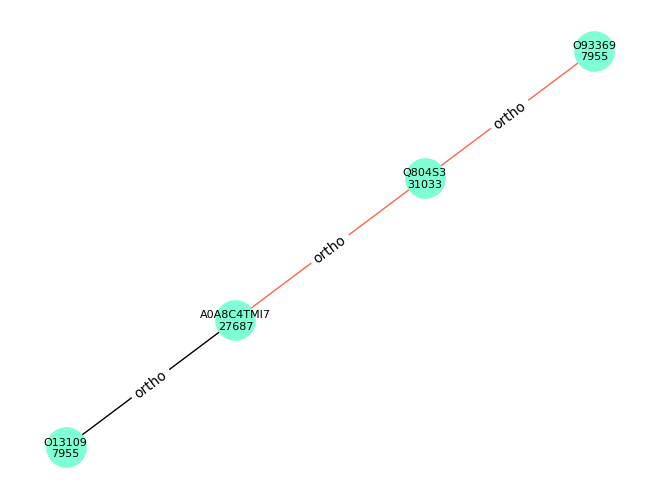

In [42]:
interest = cc[1591]
sub = G2.subgraph(interest).copy()

pos = nx.spring_layout(sub, seed=42)

edge_colors = []
for u, v, data in sub.edges(data=True):
    uv = tuple(sorted((u,v)))

    if uv in suspect_edges:
        edge_colors.append("black")
    else:
        if data.get("label") == "ortho":
            edge_colors.append("tomato")
        else:
            edge_colors.append("skyblue")

nx.draw(
    sub,
    pos,
    edge_color= edge_colors,
    node_color="aquamarine",
    node_size=800,
    font_size=8
)

edge_labels = nx.get_edge_attributes(sub, "label")
nx.draw_networkx_edge_labels(sub, pos, edge_labels=edge_labels, font_color="black")

node_labels = nx.get_node_attributes(sub, "taxid")
merged_labels = {n: f"{n}\n{attr}" for n, attr in node_labels.items()}
nx.draw_networkx_labels(sub, pos, labels=merged_labels, font_size=8)

plt.show()